**Pattern Detection**

To simply see the results see the first two and last two cells.
- First two cells contains Input
- Last two cells contins Output 

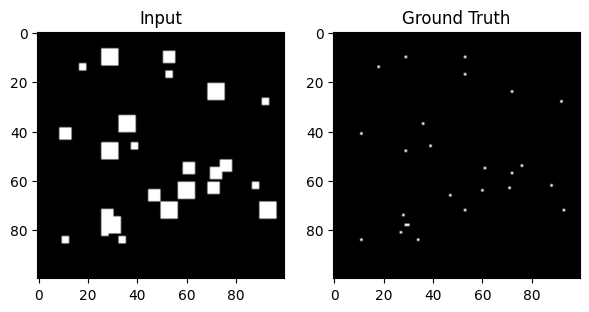

In [1]:
from random import seed
from random import randint
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm 
from PIL import Image 
import cv2

# Seeding
seed(2) 

# Size of Synthetic input
N=100                                               

# Initialization
img = np.zeros([1,N,N])                             #Input Image
noise = np.random.normal(0,0.08,(1,N,N))            #Gaussian noise
noise = noise.reshape(1,N,N)
GroundTruth = np.zeros([1,N,N])                    # GroundTruth 

img_noisy = img + noise                             # Adding Noise

# Index Variables
row = np.zeros(25,'int')                         
col = np.zeros(25,'int')

for i in range(25):
  row[i] = randint(7,N-7)
  col[i] = randint(7,N-7)


## Adding Patterns

# Patterns of size 3x3
for k in range(8):
  GroundTruth[:,row[k],col[k]] = 255
  for i in range(row[k]-1,row[k]+2):
    for j in range(col[k]-1,col[k]+2):
      img_noisy[:,i,j] = 255
  

# Patterns of size 5x5
for k in range(8,16):
  GroundTruth[:,row[k],col[k]] = 255
  for i in range(row[k]-2,row[k]+3):
    for j in range(col[k]-2,col[k]+3):
      img_noisy[:,i,j] = 255

# Patters of size 7x7
for k in range(16,25):
  GroundTruth[:,row[k],col[k]] = 255
  for i in range(row[k]-3,row[k]+4):
    for j in range(col[k]-3,col[k]+4):
      img_noisy[:,i,j] = 255

## Plotting
gray = plt.colormaps.get_cmap('gray') 
out1 = Image.fromarray((img_noisy[0,:,:]).astype(np.double))
GT1 = Image.fromarray((GroundTruth[0,:,:]).astype(np.double))

fig = plt.figure(figsize=(7, 7))
fig.add_subplot(1,2, 1)
plt.imshow(out1, cmap=gray)
plt.title('Input')

fig.add_subplot(1,2,2)
plt.imshow(GT1, cmap=gray)
plt.title('Ground Truth')
plt.savefig('Input.png')
plt.show()

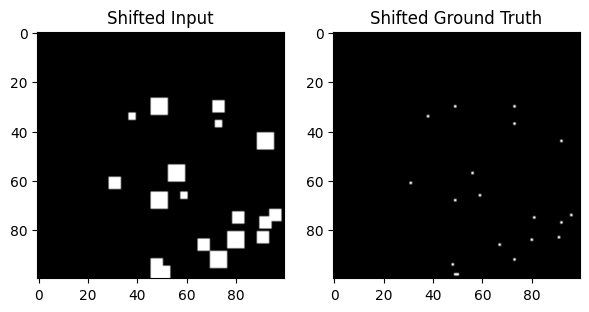

In [2]:
# Shifted Input

img_shifted = np.zeros([1,N,N]) + noise
GroundTruth_shifted = np.zeros([1,N,N])

# shifting by 20 pixels 
shift = int(N/5)                                                

for i in range(shift,N):
  for j in range(shift,N):
    img_shifted[:,i,j] = img_noisy[:,i-shift,j-shift]
    GroundTruth_shifted[:,i,j] = GroundTruth[:,i-shift,j-shift]

## Plotting
out1_shifted = Image.fromarray((img_shifted[0,:,:]).astype(np.double))
GT1_shifted = Image.fromarray((GroundTruth_shifted[0,:,:]).astype(np.double))

fig = plt.figure(figsize=(7, 7))
fig.add_subplot(1,2, 1)
plt.imshow(out1_shifted, cmap=gray)
plt.title('Shifted Input')

fig.add_subplot(1,2, 2)
plt.imshow(GT1_shifted, cmap=gray)
plt.title('Shifted Ground Truth')
plt.savefig('Shifted.png')
plt.show()

In [3]:
## Dimension Matching and Torch Conversion
import torch
# For Normal Input
img_noisy_torch = np.expand_dims(img_noisy, 1)
GroundTruth_torch = np.expand_dims(GroundTruth,1)

img_noisy_torch = torch.from_numpy(img_noisy_torch)#.cuda()
GroundTruth_torch = torch.from_numpy(GroundTruth_torch)#.cuda()

img_noisy_torch = img_noisy_torch.float()
GroundTruth_torch = GroundTruth_torch.float()

# For Shifted Input
img_shifted_torch = np.expand_dims(img_shifted, 1)
GroundTruth_shifted_torch = np.expand_dims(GroundTruth_shifted,1)

img_shifted_torch = torch.from_numpy(img_shifted_torch)#.cuda()
GroundTruth_shifted_torch = torch.from_numpy(GroundTruth_shifted_torch)#.cuda()

img_shifted_torch = img_shifted_torch.float()
GroundTruth_shifted_torch = GroundTruth_shifted_torch.float()

**Next two cells are ACDA layer defining cells**

In [4]:
'''
The code is directly taken from https://github.com/ZeWang95/ACDA, which was translated from the matlab code 
https://github.com/xycheng/DCFNet/blob/master/calculate_FB_bases.m
'''
## Functions for calculating bases 

import numpy as np 
from scipy import special
import pdb


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (phi, rho)

def calculate_FB_bases(L1):
	maxK = (2 * L1 + 1)**2 - 1

	L = L1 + 1
	R = L1 + 0.5

	truncate_freq_factor = 1.5

	if L1 < 2:
		truncate_freq_factor = 2

	xx, yy = np.meshgrid(range(-L, L+1), range(-L, L+1))

	xx = xx/R
	yy = yy/R

	ugrid = np.concatenate([yy.reshape(-1,1), xx.reshape(-1,1)], 1)
	tgrid, rgrid = cart2pol(ugrid[:,0], ugrid[:,1])

	num_grid_points = ugrid.shape[0]

	kmax = 15

	bessel = np.load('bessel.npy')

	B = bessel[(bessel[:,0] <=kmax) & (bessel[:,3]<= np.pi*R*truncate_freq_factor)]

	idxB = np.argsort(B[:,2])

	mu_ns = B[idxB, 2]**2

	ang_freqs = B[idxB, 0]
	rad_freqs = B[idxB, 1]
	R_ns = B[idxB, 2]

	num_kq_all = len(ang_freqs)
	max_ang_freqs = max(ang_freqs)

	Phi_ns=np.zeros((num_grid_points, num_kq_all), np.float32)

	Psi = []
	kq_Psi = []
	mdash_bases=0

	for i in range(B.shape[0]):
		ki = ang_freqs[i]
		qi = rad_freqs[i]
		rkqi = R_ns[i]

		r0grid=rgrid*R_ns[i]

		F = special.jv(ki, r0grid)

		Phi = 1./np.abs(special.jv(ki+1, R_ns[i]))*F

		Phi[rgrid >=1]=0

		Phi_ns[:, i] = Phi

		if ki == 0:
			Psi.append(Phi)
			kq_Psi.append([ki,qi,rkqi])
			mdash_bases = mdash_bases+1

		else:
			Psi.append(Phi*np.cos(ki*tgrid)*np.sqrt(2))
			Psi.append(Phi*np.sin(ki*tgrid)*np.sqrt(2))
			kq_Psi.append([ki,qi,rkqi])
			kq_Psi.append([ki,qi,rkqi])
			mdash_bases = mdash_bases+2

	Psi = np.array(Psi)
	kq_Psi = np.array(kq_Psi)

	mdash_bases = Psi.shape[1]

	if mdash_bases > maxK:
		Psi = Psi[:maxK]
		kq_Psi = kq_Psi[:maxK]
	mdash_bases = Psi.shape[0]
	p = Psi.reshape(mdash_bases, 2*L+1, 2*L+1).transpose(1,2,0)
	psi = p[1:-1, 1:-1, :]
	
	psi = psi.reshape((2*L1+1)**2, mdash_bases)

	c = np.sqrt(np.sum(psi**2, 0).mean())

	psi = psi/c

	return psi, c, kq_Psi


In [5]:
## ACDA Main Code

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils import spectral_norm
from torch.autograd import Variable
from torch.nn.parameter import Parameter

import math
import scipy as sp
import scipy.linalg as linalg
import numpy as np
import pdb
import matplotlib as plt

class Adaptive_Convolution(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, num_bases=6, 
                 bias=True, dilation=1, groups=1):
      
        super(Adaptive_Convolution, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_bases = num_bases
        self.dilation = dilation
        self.groups = groups

        
        # Making a list of bases
        list_size = kernel_size // 2
        bases_list = []

        # Creating/Calulating Bases  
        for i in range(list_size):
            kss = (i+1)*2+1
            FB_bases, _, _ = calculate_FB_bases(i+1)    
            FB_bases = FB_bases.transpose().reshape(-1, kss, kss).astype(np.float32)[:num_bases, ...]
            pad = list_size - (i+1)
            bases1 = torch.Tensor(FB_bases)
            bases1 = F.pad(bases1, (pad, pad, pad, pad, 0, 0)).view(num_bases, kernel_size*kernel_size)
            bases_list.append(bases1)
            
        bases = torch.cat(bases_list,0)
        bases_size = num_bases * len(bases)
        

        self.register_buffer('bases', torch.Tensor(bases).float())
        self.tem_size = len(bases)
        
        inter = max(64, bases_size//2)  
        
        # Defining Bases Coefficient Generation Network 
        # Dynamic Atoms are a linear combination of pre-fixed bases and bases coefficients
        # Below Network generates the bases coefficients
        self.bases_coeff_gen = nn.Sequential(
            nn.Conv2d(in_channels, inter, kernel_size=self.kernel_size, padding=1, stride=stride), 
            nn.BatchNorm2d(inter),
            nn.Tanh(),
            nn.Conv2d(inter, bases_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(bases_size),
            nn.Tanh()
            )

        # Calculating Composition Coefficients 
        self.composition_coeffcients = Parameter(torch.Tensor(out_channels, in_channels*num_bases, 1, 1))
        
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)


    def forward(self, input):
        N, C, H, W = input.shape

        H = (H + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1)//self.stride + 1
        W = (W + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1)//self.stride + 1
        M = self.num_bases
        

        drop_rate = 0.0

        ## Two-Layer Implementation  
        
        ##First Layer
        #Generating bases coefficeints using bases coefficient generation network
        bases = self.bases_coeff_gen(F.dropout2d(input, p=drop_rate, training=self.training)).view(N, self.num_bases, self.tem_size, H, W) 
       
        self.bases_coef = bases.cpu().data.numpy()

        bases = torch.einsum('bmkhw, kl->bmlhw', bases, self.bases)
        self.bases_save = bases.cpu().data.numpy()

        x = F.unfold(F.dropout2d(input, p=drop_rate, training=self.training), kernel_size=self.kernel_size, stride=self.stride, padding=self.padding).view(N, self.in_channels, self.kernel_size*self.kernel_size, H, W)
        
        #Intermittent I' Layer
        middle_layer = torch.einsum('bmlhw, bclhw-> bcmhw', bases.view(N, self.num_bases, -1, H, W), x).reshape(N, self.in_channels*self.num_bases, H, W)
        middle_layer = F.dropout2d(middle_layer, p=drop_rate, training=self.training)

        pad = ((self.kernel_size - 3)/2)//self.stride
        pad = int(pad)

        ##Second Layer 
        #Convolution with Composition Coefficients
        output = F.conv2d(middle_layer, self.composition_coeffcients, self.bias,stride=self.stride, padding=pad, dilation=self.dilation, groups=self.groups)

        return output

In [6]:
## Normal Neural Network

import torch  
import torch.nn as nn  
from torch import relu
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=(7,7),padding = "same")
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.batchnorm = nn.BatchNorm2d(1)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = self.upsample(x)
        x = self.batchnorm(x)
        return x


model = NeuralNet()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 100
for i in range(epochs):  
    norm_pred = model.forward(img_noisy_torch)
    loss = criterion(norm_pred,GroundTruth_torch)  

    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step() 

for i in range(epochs):  
    shifted_pred = model.forward(img_shifted_torch)
    loss=criterion(shifted_pred,GroundTruth_shifted_torch)  

    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step() 


In [7]:
## ACDA Network
class NeuralNet1(nn.Module):
    def __init__(self):
        super(NeuralNet1, self).__init__()

        self.acda = Adaptive_Convolution(1, 1, kernel_size=7, padding=1, stride=1, bias=True)#.cuda()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.batchnorm = nn.BatchNorm2d(1)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.acda(x)
        x = self.batchnorm(x)
        return x


model1 = NeuralNet1()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

# Normal Input
epochs = 100
for i in range(epochs):  
    norm_pred_ACDA = model1.forward(img_noisy_torch)  
    loss = criterion(norm_pred_ACDA,GroundTruth_torch)  

    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step() 

# Shifted Input
for i in range(epochs):  
    shifted_pred_ACDA = model1.forward(img_shifted_torch)  
    loss = criterion(shifted_pred_ACDA,GroundTruth_shifted_torch)  

    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step() 

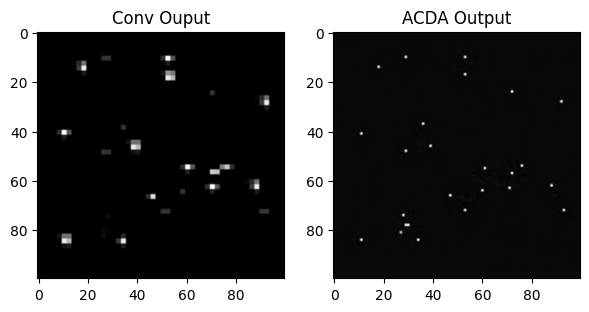

In [8]:
from torch import tensor
import matplotlib.pyplot as plt

## Conversion and Plotting Output

norm_output = norm_pred[0,:,:,:]
norm_output_ACDA = norm_pred_ACDA[0,:,:,:]

tensor_image = norm_output.squeeze()
tensor_image_ACDA = norm_output_ACDA.squeeze()

tensor_image = tensor_image.cpu()
tensor_image_ACDA = tensor_image_ACDA.cpu()

opt = tensor_image.detach().cpu().numpy()
opt_ACDA = tensor_image_ACDA.detach().cpu().numpy()

 
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(1,2, 1)
plt.imshow(opt,cmap=gray)
plt.title('Conv Ouput')

fig.add_subplot(1,2, 2)
plt.imshow(opt_ACDA, cmap=gray)
plt.title('ACDA Output')
plt.show()

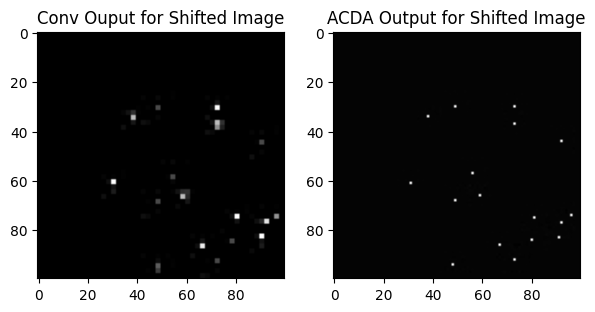

In [9]:
from torch import tensor

## Conversion and Plotting shifted Output

norm_output_shifted = shifted_pred[0,:,:,:]
output_ACDA_shifted = shifted_pred_ACDA[0,:,:,:]

tensor_image_s = norm_output_shifted.squeeze()
tensor_image_ACDA_s = output_ACDA_shifted.squeeze()

tensor_image_s = tensor_image_s.cpu()
tensor_image_ACDA_s = tensor_image_ACDA_s.cpu()

opt_s = tensor_image_s.detach().cpu().numpy()
opt_ACDA_s = tensor_image_ACDA_s.detach().cpu().numpy()

fig = plt.figure(figsize=(7, 7))
fig.add_subplot(1,2, 1)
plt.imshow(opt_s,cmap=gray)
plt.title('Conv Ouput for Shifted Image')

fig.add_subplot(1,2, 2)
plt.imshow(opt_ACDA_s, cmap=gray)
plt.title('ACDA Output for Shifted Image')
plt.show()